# Otimiza√ß√£o

Para entender o processo de otimiza√ß√£o, vamos utilizar um dataset de classifica√ß√£o de vinhos. A classifica√ß√£o √© feita com base em an√°lises qu√≠micas realizadas em **tr√™s diferentes cultivos** na mesma regi√£o da It√°lia. 

O carregamento dos dados est√° descrito na documenta√ß√£o do Scikit-Learn:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

Dentre os 13 atributos do dataset, selecionamos 2 para facilitar a visualiza√ß√£o dos resultados:
* Teor Alco√≥lico: √≠ndice 0 
* Intensidade da cor: √≠ndice 9

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


Text(0, 0.5, 'color_intensity')

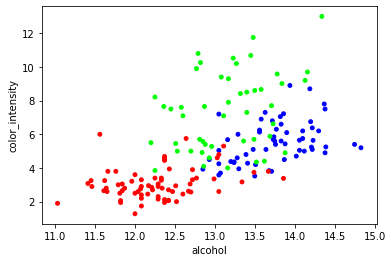

In [62]:
from sklearn import datasets
import matplotlib.pyplot as plt

features = [0, 9]

wine = datasets.load_wine()
data = wine.data[:, features]
targets = wine.target

print(wine.feature_names)

plt.scatter(data[:, 0], data[:,1], c=targets, s=15, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

### Padroniza√ß√£o

Um pr√©-processamento extremamente importante nesse caso √© a padroniza√ß√£o dos valores de entrada. Como as caracter√≠sticas variam em intervalos diferentes (cor: [1, 13], √°lcool: [11, 15]), elas v√£o exercer diferentes influ√™ncias sobre o nosso modelo e prejudicar muito a sua converg√™ncia. 

* **Ao final dessa aula, sugiro que rode esse script comentando a c√©lula abaixo, e veja o impacto sobre o processo de otimiza√ß√£o.**

Text(0, 0.5, 'color_intensity')

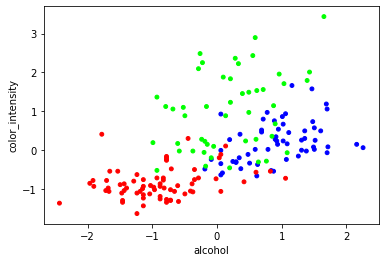

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

plt.scatter(data[:, 0], data[:,1], c=targets, s=15, cmap=plt.cm.brg)
plt.xlabel(wine.feature_names[features[0]])
plt.ylabel(wine.feature_names[features[1]])

## Instanciando sua rede

Antes de entrar nas nuances da otimiza√ß√£o, vamos fazer o que j√° sabemos: instanciar um MLP de duas camadas neurais, uma escondida e outra de sa√≠da.

Lembre-se de definir o dispositivo de hardware (cuda ou cpu) antes de iniciar os trabalhos. 


In [64]:
import torch
from torch import nn

torch.manual_seed(42)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

input_size  = data.shape[1]
hidden_size = 32
out_size    = len(wine.target_names) # numero de classes 

net = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, out_size),
    nn.Softmax()
)

net = net.to(device)

cuda


## Visualizando a fronteira de decis√£o

Para facilitar o entendimento do processo de otimiza√ß√£o, vamos utilizar uma fun√ß√£o auxiliar para visualizar a fronteira de decis√£o da nossa rede neural de classifica√ß√£o. Como acabamos de instanci√°-la, seus pesos modelam uma fun√ß√£o aleat√≥ria que n√£o se ajusta adequadamente aos dados, e isso √© facilmente vis√≠vel em duas dimens√µes.

Adaptada de:<br>
https://github.com/camilalaranjeira/Neural-Lectures/blob/master/XOR_Problem.ipynb

In [0]:
import numpy as np 

def plot_boundary(X, y, model):
  x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
  y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
  
  spacing = min(x_max - x_min, y_max - y_min) / 100
  
  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))
  
  data = np.hstack((XX.ravel().reshape(-1,1), 
                    YY.ravel().reshape(-1,1)))
  
  # For binary problems
  # db_prob = model(Variable(torch.Tensor(data)).cuda() )
  # clf = np.where(db_prob.cpu().data < 0.5,0,1)
  
  # For multi-class problems
  db_prob = model(torch.Tensor(data).to(device) )
  clf = np.argmax(db_prob.cpu().data.numpy(), axis=-1)
  
  Z = clf.reshape(XX.shape)
  
  plt.contourf(XX, YY, Z, cmap=plt.cm.brg, alpha=0.5)
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=25, cmap=plt.cm.brg)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


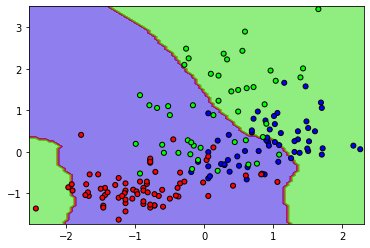

In [66]:
plot_boundary(data, targets, net)

## Pacote ```torch.optim```

M√£os a obra! Vamos agora otimizar a nossa rede usando os algoritmos mais tradicionais da √°rea. Para isso, a biblioteca ```torch.optim``` nos ser√° bem √∫til, pois ela implementa os principais algoritmos de otimiza√ß√£o de redes neurais.

O primeiro passo √© instanciar o otimizador. De acordo com o pacote ```optim```, basta chamar o otimizador escolhido, passando como par√¢metro:
* Os par√¢metros da rede que ser√° otimizada (```net.parameters()```)
* A taxa de aprendizado

A depender do otimizador, pode ser necess√°rio alimentar outros par√¢metros, mas esses dois s√£o obrigat√≥rios!

Vamos utilizar a **Descida do Gradiente** que vimos na aula te√≥rica, implementada pelo otimizador **```optim.SGD```** (*Stochastic Gradient Descent*).

In [0]:
from torch import optim

# Fun√ß√£o de Perda
criterion = nn.CrossEntropyLoss().to(device)

# Otimizador: Descida do Gradiente
# Stochastic Gradient Descent
optimizer = optim.SGD(net.parameters(), lr=1e-3)

### Hiperpar√¢metros

* Valores definidos antes do in√≠cio do aprendizado
* Devem ser ajustados para cada tarefa espec√≠fica

A taxa de aprendizado n√£o √© o primeiro hiperpar√¢metro que temos contato. Ao definir a arquitetura da sua rede (quantos neur√¥nios e quantas camadas) voc√™ tamb√©m teve que escolher um valor adequado. **Essa escolha pode ser emp√≠rica, mas em geral deve ser experimental**, na busca pelo melhor conjunto de hiperpar√¢metros para solucionar o seu problema! 

* üêº Emp√≠rica ([Abordagem do Panda](https://www.coursera.org/lecture/deep-neural-network/hyperparameters-tuning-in-practice-pandas-vs-caviar-DHNcc)): O programador investe seus esfor√ßos em um √∫nico modelo (um beb√™ panda), e altera os hiperpar√¢metros com base na sua experi√™ncia e nas observa√ß√µes
* üíª Experimental: M√∫ltiplos modelos s√£o gerados simultaneamente, com diferentes combina√ß√µes de hiperpar√¢metros. Dentre eles, √© escolhido o que apresentar melhor performance.  

## Cast do dados

Os dados carregados do Scikit-Learn s√£o retornados como ```ndarrays```, por isso precisamos convert√™-los para tensores e carreg√°-los na GPU (caso dispon√≠vel) antes de alimentar o modelo neural.


In [0]:
X = torch.FloatTensor(data).to(device) # GPU
Y = torch.LongTensor(targets).to(device)

## Treinando um modelo

O treinamento consiste nas etapas que vimos na aula te√≥rica. Aqui vamos relacionar cada etapa ao seu c√≥digo correspondente.

* Forward
  * Alimentar os dados para a rede <br>
  ```pred = net(X)```
  * Calcular a fun√ß√£o de custo <br>
  ```loss = criterion(pred, y)```
* Backpropagation
  * Calcular o gradiente <br>
  ```loss.backward()```
  * Atualizar os pesos <br>
  ```optimizer.step()```


A princ√≠pio n√£o vamos falar de procedimentos adequados de treinamento. Vamos apenas realizar as etapas de treinamento e ver o que acontece.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


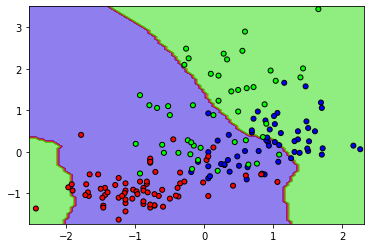

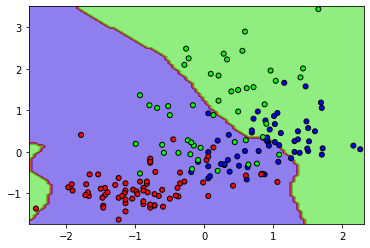

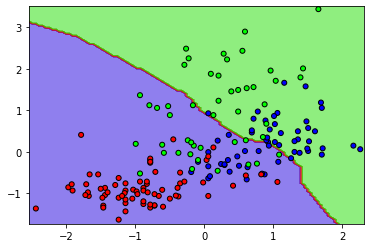

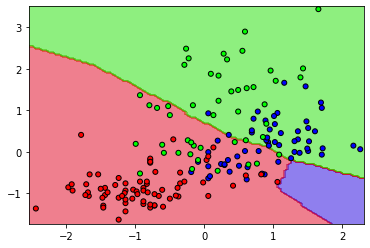

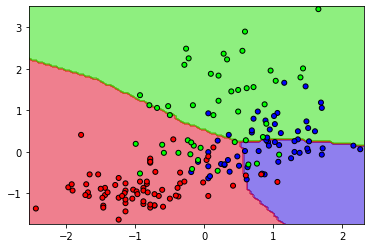

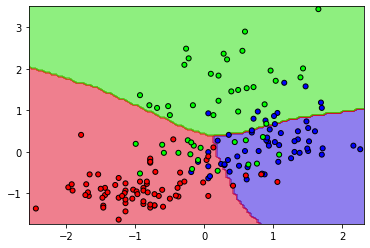

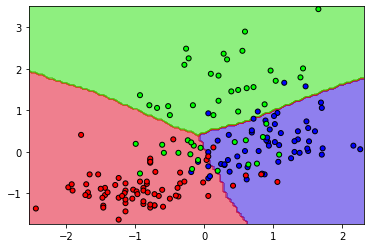

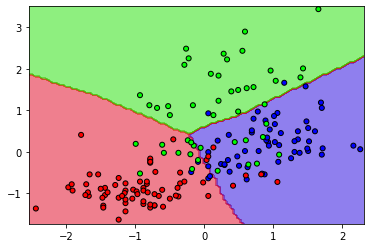

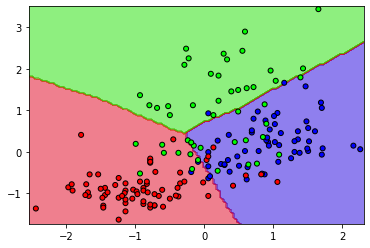

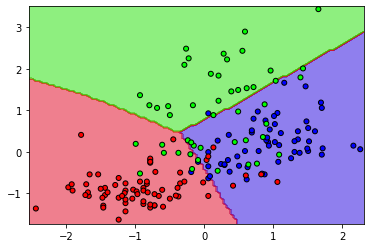

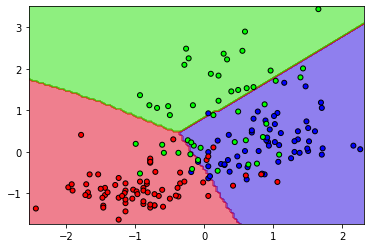

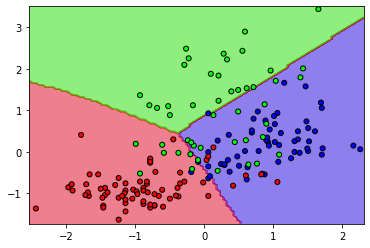

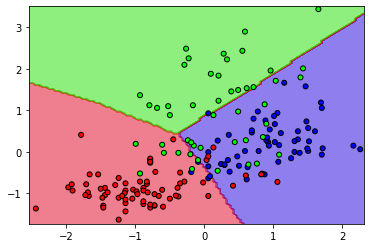

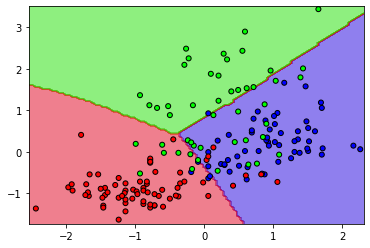

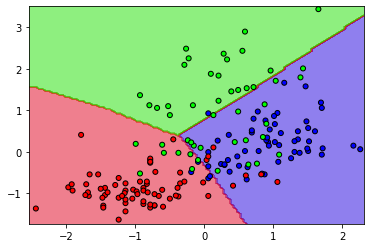

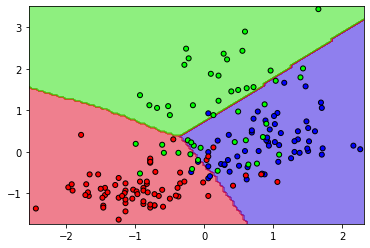

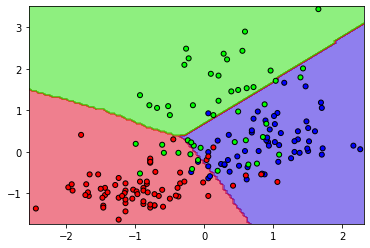

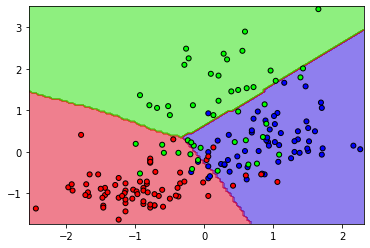

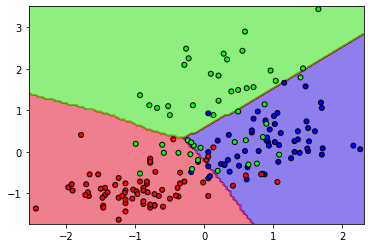

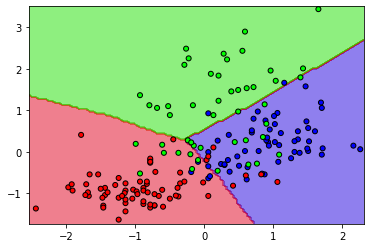

In [69]:
for i in range(200):
  # Forward 
  pred = net(X)
  loss = criterion(pred, Y)

  # Backward
  loss.backward()
  optimizer.step()

  if i % 10 == 0:
    plt.figure()
    plot_boundary(data, targets, net)

## Treinamento: Conclus√£o

Como a otimiza√ß√£o de uma rede neural √© um processo iterativo, os dados de treino devem ser alimentados m√∫ltiplas vezes para o modelo. **Cada itera√ß√£o onde o conjunto de treino inteiro foi utilizado no processo de treinamento √© chamado de <font color='color'>√©poca</font>.** Veremos essas nomenclaturas em detalhes nas aulas futuras.